# Problem 2 - Gaussian Mixture Models

## Problem 2.1 - GMM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import load_wine
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from sklearn.metrics import silhouette_score

In [2]:
class GMM():
    def __init__(self, num_components=3, max_iters=100, threshold=1e-5):
        self.num_components   = num_components
        self.max_iters        = max_iters
        self.num_iters        = 0
        self.threshold        = threshold
        self.means            = None
        self.weights          = None
        self.covariances      = None
        self.responsibilities = None
        self.log_likelihood   = 0
        self.epsilon          = np.finfo(float).eps
        self.aic_score        = 0
        self.bic_score        = 0

    def get_params(self):
        return self.weights, self.means, self.covariances
    
    def calculate_log_likelihoods(self, X):
        for k in range(self.num_components):
            self.responsibilities[:, k] = self.weights[k] * multivariate_normal(self.means[k], self.covariances[k]).pdf(X)
    
    def __E_step(self, X):
        self.calculate_log_likelihoods(X)

        # Adding epsilon to the sum of responsibilities to ensure that both the log likelihood and the normalisation of responsibilities do not blow up when the sum tends to 0
        present_log_likelihood = np.sum(np.log(np.sum(self.responsibilities, axis=1) + self.epsilon))
        self.responsibilities = self.responsibilities / (np.sum(self.responsibilities, axis=1)[:, None] + self.epsilon)

        return present_log_likelihood
    
    def __M_step(self, X):
        Nk = np.sum(self.responsibilities, axis=0)
        self.weights = Nk / X.shape[0]
        self.means = np.dot(self.responsibilities.T, X) / Nk[:, None]

        # (x- mu).T * sigma @ (x - mu)
        # An epsilon is added to the diagonal elements of the covariance matrix to prevent it from becoming singular and to ensure it is positive definite
        self.covariances = np.transpose(X - self.means[:, None], (0, 2, 1)) @ (self.responsibilities.T[:, :, None] * (X - self.means[:, None])) / Nk[:, None, None] + np.eye(X.shape[1]) * 1e-6

    def __is_converged(self, present_log_likelihood):
        return abs(self.log_likelihood - present_log_likelihood) <= self.threshold
    
    # Number of parameters of the model = For each component, num_features * (num_features + 1) / 2 values from the covariance matrix,
    #  as the upper half is covered in the lowe half due to its symmetric nature + num_features from the mean + 1 weight per component
    
    def __aic_score(self, X):
        num_params = self.num_components * (X.shape[1] + 1) * (X.shape[1] + 2) / 2
        return -2 * self.log_likelihood + 2 * num_params
    
    def __bic_score(self, X):
        num_params = self.num_components * (X.shape[1] + 1) * (X.shape[1] + 2) / 2
        return -2 * self.log_likelihood + np.log(X.shape[0]) * num_params

    def fit(self, X):
        self.means              =   X[np.random.choice(X.shape[0], self.num_components, replace=False)]         # k values
        self.weights            =   np.full(self.num_components, 1 / self.num_components)                       # k values
        self.covariances        =   np.full((self.num_components, X.shape[1], X.shape[1]), np.eye(X.shape[1]))  # k matrices of dimension (n, n)
        self.responsibilities   =   np.zeros((X.shape[0], self.num_components))                                 # Probability of x_i belonging to component j -> Matrix of dimensions (n, k)

        log_likelihood = 0
        for _ in range(self.max_iters):
            self.num_iters += 1

            log_likelihood = self.__E_step(X)
            self.__M_step(X)
            
            if self.__is_converged(log_likelihood):
                break

            self.log_likelihood = log_likelihood

        self.log_likelihood = log_likelihood
        self.aic_score      = self.__aic_score(X)
        self.bic_score      = self.__bic_score(X)

    def get_membership_data(self):
        """
        The component which has the highest probability of generating the ith point is considered to be the actual generator
        """
        return np.argmax(self.responsibilities, axis=1)

In [3]:
data_df = pd.read_csv('./Data/GMM/data.csv')
display(data_df)

customer_data = data_df.to_numpy()
customer_data = customer_data[:, 1:]
customer_data = (customer_data - np.mean(customer_data, axis=0)) / np.std(customer_data, axis=0)

,Index,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,0,67,2,124670,1,2
1,1,1,1,22,1,150773,1,2
2,2,0,0,49,1,89210,0,0
3,3,0,0,45,1,171565,1,1
4,4,0,0,53,1,149031,1,1
...,...,...,...,...,...,...,...,...
1995,1995,1,0,47,1,123525,0,0
1996,1996,1,1,27,1,117744,1,0
1997,1997,0,0,31,0,86400,0,0
1998,1998,1,1,24,1,97968,0,0


#### Comparision between the coded GMM model and the external GMM model and ensuring convergence is reached by comparing the weights to each component

In [4]:
np.random.seed(5)

gmm = GMM()
gmm.fit(customer_data)

sklearn_gmm = GaussianMixture(n_components=3, max_iter=100, tol=1e-5)
sklearn_gmm.fit(customer_data)

print(gmm.weights)
print(sklearn_gmm.weights_)
print()

print(gmm.num_iters)
print(sklearn_gmm.n_iter_)

[0.41449855 0.346903   0.2385984 ]
[0.34690278 0.41449855 0.23859867]

10
8


### Problem 2.1.1 - Parameters of the GMM - Weights, Means and Covariances, and how they vary with varying number of components

In [5]:
components = range(1, 10, 2)

for i in components:
    gmm = GMM(i)
    gmm.fit(customer_data)

    weights, means, covariances = gmm.get_params()

    print(f"Number of components: {i}")
    print("=======================================")
    print(weights)
    print()
    print(means)
    print()
    print(covariances)
    print("=======================================")
    print()

Number of components: 1
[0.99997032]

[[ 2.58687350e-05 -2.98930590e-05  2.73986575e-05 -9.70967623e-05
  -7.11813574e-05 -5.31048452e-05 -4.60690633e-05]]

[[[ 1.00000547  0.56655354 -0.1829145   0.24492951 -0.19508737
   -0.20244683 -0.30077198]
  [ 0.56655354  1.00000058 -0.21315709  0.37392986 -0.07360159
   -0.02954394 -0.09708988]
  [-0.1829145  -0.21315709  1.00000531  0.65471406  0.34068644
    0.10844093  0.11979737]
  [ 0.24492951  0.37392986  0.65471406  0.99971297  0.23323282
    0.06435197  0.0345826 ]
  [-0.19508737 -0.07360159  0.34068644  0.23323282  0.99985648
    0.68024555  0.49078506]
  [-0.20244683 -0.02954394  0.10844093  0.06435197  0.68024555
    0.99992913  0.5717294 ]
  [-0.30077198 -0.09708988  0.11979737  0.0345826   0.49078506
    0.5717294   0.99995917]]]

Number of components: 3
[0.09548243 0.72601754 0.17850004]

[[ 2.70097182e-01  1.00702467e+00 -1.67898842e-01  6.17684764e-01
   4.87393863e-01  5.91970371e-01  1.55232600e+00]
 [-5.60533662e-02 -1.34849

### Problem 2.1.2 - PCA on the wine dataset and clustering using GMM

#### Performing PCA on the wine dataset by considering only the first two principal components

In [6]:
wine_data, wine_labels = load_wine(return_X_y=True)
wine_data = (wine_data - np.mean(wine_data, axis=0)) / np.std(wine_data, axis=0)
reduced_wine_data = PCA(n_components=2).fit_transform(wine_data)

#### Calculating the best number of components using the AIC and BIC scores

In [7]:
gmm_aic, gmm_bic = [], []
sklearn_aic, sklearn_bic = [], []
num_components_list = range(1, 11)

for i in num_components_list:
    gmm = GMM(num_components=i, max_iters=500, threshold=1e-5)
    gmm.fit(reduced_wine_data)
    gmm_aic.append(gmm.aic_score)
    gmm_bic.append(gmm.bic_score)

    sklearn_gmm = GaussianMixture(n_components=i, max_iter=500, tol=1e-5)
    sklearn_gmm.fit(reduced_wine_data)
    sklearn_aic.append(sklearn_gmm.aic(reduced_wine_data))
    sklearn_bic.append(sklearn_gmm.bic(reduced_wine_data))

#### Observing the plots of the scores to determine the best number of components by taking the best of both

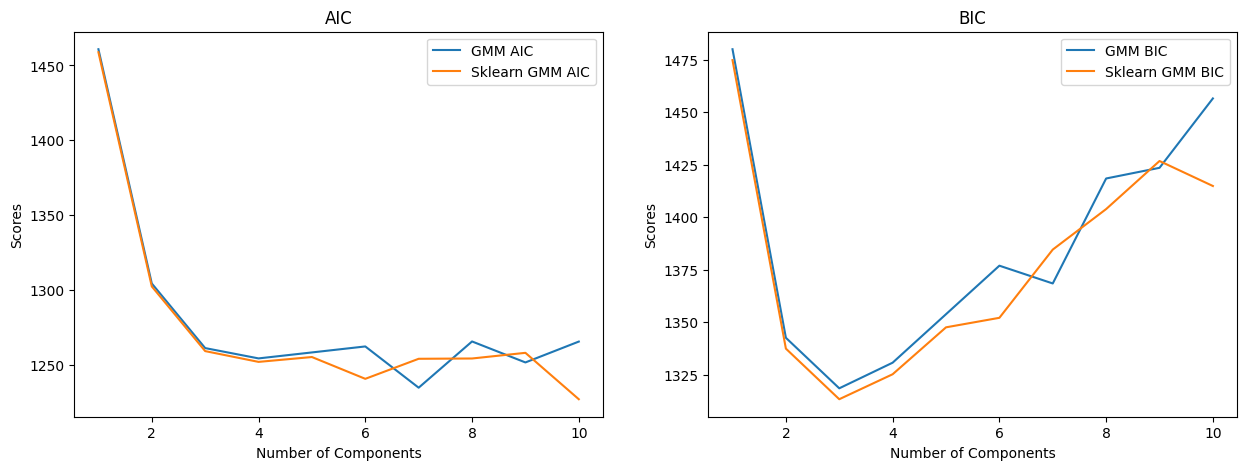

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(num_components_list, gmm_aic, label='GMM AIC')
axs[0].plot(num_components_list, sklearn_aic, label='Sklearn GMM AIC')
axs[0].set_xlabel('Number of Components')
axs[0].set_ylabel('Scores')
axs[0].set_title('AIC')
axs[0].legend()

axs[1].plot(num_components_list, gmm_bic, label='GMM BIC')
axs[1].plot(num_components_list, sklearn_bic, label='Sklearn GMM BIC')
axs[1].set_xlabel('Number of Components')
axs[1].set_ylabel('Scores')
axs[1].set_title('BIC')
axs[1].legend()

plt.show()

- #### As we can see from the AIC plot, the descent of the plot slows down after 3 components and the minima of the BIC plot is at 3 components as well
- #### So, we can cocnlude the best number of components to be 3

#### Silhouette score requires the membership data of each point and the higher the score the better the clustering

In [9]:
gmm = GMM(num_components=3, max_iters=500, threshold=1e-5)
gmm.fit(reduced_wine_data)
gmm_labels = gmm.get_membership_data()
gmm_silhouette_score = silhouette_score(reduced_wine_data, gmm_labels)

kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans.fit(reduced_wine_data)
kmeans_labels = kmeans.labels_
kmeans_silhouette_score = silhouette_score(reduced_wine_data, kmeans_labels)

print(gmm_silhouette_score, kmeans_silhouette_score)

0.5581473461293222 0.5609305721582906


#### Scatter plot of the clusters which are colour coded based on the cluster they belong to 

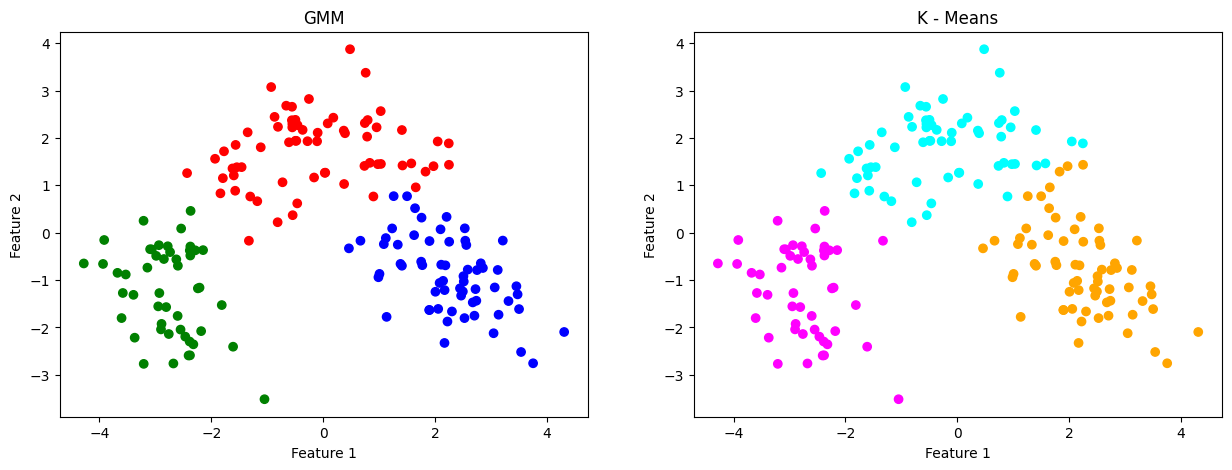

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

gmm_colors = np.array(['red', 'green', 'blue'])
axs[0].scatter(reduced_wine_data[:, 0], reduced_wine_data[:, 1], c=gmm_colors[gmm_labels])
axs[0].set_title('GMM')
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')


kmeans_colors = np.array(['cyan', 'magenta', 'orange'])
axs[1].scatter(reduced_wine_data[:, 0], reduced_wine_data[:, 1], c=kmeans_colors[kmeans_labels])
axs[1].set_title('K - Means')
axs[1].set_xlabel('Feature 1')
axs[1].set_ylabel('Feature 2')

plt.show()

- #### We can observe that the clusters generated by the GMM can be fit into approximately elliptical clusters
- #### Contrastingly, the clusters of K-Means are of spherical shape as the algorithm tries to minimise the distance of all points from the center of the cluster, the mean